In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import simweights
import pickle
import os, sys
import re
import numpy as np

from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager


In [3]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/notebooks/weighting")
from weights import *
from utils import *
from selections import selection_mask
from fonts import *
from plot_utils import *

In [4]:
# Append the custom module path
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing")

simulation_datasets = {}

# Import the datasets module
from datasets import datasets_analysis as datasets
reco_versions = ["taureco_iceprod_v5"]
for reco_version in reco_versions: simulation_datasets[reco_version] = getattr(datasets, reco_version)


In [5]:
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

In [6]:
plotting_path = f"/data/user/tvaneede/GlobalFit/reco_processing/notebooks/burn/weight_simulations_christopher"
os.system(f"mkdir -p {plotting_path}")

0

In [7]:
# weight functions
gamma_astro = 2.87
per_flavor_norm = 2.12
AstroFluxModel_HESE = create_AstroFluxModel(per_flavor_norm=per_flavor_norm, gamma_astro=gamma_astro)

gamma_astro = 2.53
per_flavor_norm = 1.66
AstroFluxModel_cascade = create_AstroFluxModel(per_flavor_norm=per_flavor_norm, gamma_astro=gamma_astro)

In [8]:
def open_datasets( simulation_dataset, keys_to_merge ):

    # open the files
    for key in simulation_dataset:
        print(f"----- Extracting files for {key}")
        simulation_dataset[key]['hdf_file'] = pd.HDFStore(simulation_dataset[key]['hdf_file_path'],'r')
        if "Muon" in key: simulation_dataset[key]['weighter'] = None
        else: simulation_dataset[key]['weighter'] = simweights.NuGenWeighter( simulation_dataset[key]['hdf_file'] ,nfiles=simulation_dataset[key]['nfiles'])

    # merging files
    for new_key in keys_to_merge:
        print(f"----- Creating new key {new_key}")
        simulation_dataset[new_key] = {}
        simulation_dataset[new_key]['variables'] = {}
        simulation_dataset[new_key]['weighter'] = None

        for key in keys_to_merge[new_key]:
            
            print(f"Using {key}")
            # merge the weighters
            if simulation_dataset[new_key]['weighter'] == None:
                simulation_dataset[new_key]['weighter'] = simulation_dataset[key]['weighter']
            else: simulation_dataset[new_key]['weighter'] += simulation_dataset[key]['weighter']

    return simulation_dataset



In [9]:
keys_to_merge = {}

keys_to_merge["taureco_iceprod_v5"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}



In [10]:
for key in simulation_datasets: simulation_datasets[key] = open_datasets( simulation_datasets[key], keys_to_merge[key] )

----- Extracting files for NuE_highE
----- Extracting files for NuE_midE
----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuMu_highE
----- Extracting files for NuMu_midE
----- Creating new key NuE
Using NuE_midE
Using NuE_highE
----- Creating new key NuMu
Using NuMu_midE
Using NuMu_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuE
Using NuMu
Using NuTau


In [11]:
dataset_label_dict = {
    "taureco_iceprod_v5" : "iceprod",
}

check if merging works now, seems to be fine

In [13]:
data = {}

for key in simulation_datasets:

    simulation_dataset = simulation_datasets[key]

    channel_data = {}

    for flavor in ['NuE', "NuMu", "NuTau"]:
        if "HESE" in key:
            weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel_HESE) * livetime_s
        else:
            weights = simulation_dataset[flavor]["weighter"].get_weights(AstroFluxModel_cascade) * livetime_s
        rate = np.sum(weights)
        error = np.sqrt(np.sum(weights**2))
        channel_data[f"astro_{flavor}"] = f"{rate:.2f} ± {error:.2f}"

    # Conventional
    flavor = "NuAll"
    weights_conv = simulation_dataset[flavor]["weighter"].get_weights(generator_conv) * livetime_s
    rate_conv = np.sum(weights_conv)
    err_conv = np.sqrt(np.sum(weights_conv**2))
    channel_data["conv"] = f"{rate_conv:.3f} ± {err_conv:.3f}"

    # Prompt
    weights_prompt = simulation_dataset[flavor]["weighter"].get_weights(generator_pr) * livetime_s
    rate_prompt = np.sum(weights_prompt)
    err_prompt = np.sqrt(np.sum(weights_prompt**2))
    channel_data["prompt"] = f"{rate_prompt:.2f} ± {err_prompt:.2f}"

    data[ dataset_label_dict[key] ] = channel_data

# Create DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Optional: specify column order
columns_order = [f"astro_{flavor}" for flavor in ['NuE', 'NuMu', 'NuTau']] + ["conv", "prompt"]
df = df[columns_order]

# Display as string table
print(df.to_string())

            astro_NuE    astro_NuMu   astro_NuTau            conv        prompt
iceprod  49.37 ± 0.29  21.09 ± 0.13  32.82 ± 0.22  41.469 ± 0.730  13.43 ± 0.07


In [ ]:
def plot_distribution(
        base_key="evtgen_v4_rec_v9",
        base_var_key1="I3MCWeightDict",
        base_var_key2="PrimaryNeutrinoEnergy",
        variable_name="PrimaryNeutrinoEnergy [GeV]",
        bins=np.geomspace(1e4, 1e6, 20),
        xscale="log", yscale="log",
        savename="PrimaryNeutrinoEnergy",
    ):
    
    labels = ["Atmos NuAll","Astro Nue", "Astro NuMu", "Astro NuTau"]
    flavors = ["NuAll", "NuE", "NuMu", "NuTau"]
    colors  = ["black","C0", "C2", "C3"]

    bin_centers = (bins[:-1] + bins[1:]) / 2

    fig = plt.figure(figsize=(9, 8))
    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)

    fig.suptitle(rf"Variable {variable_name}", fontsize=16)

    ax = fig.add_subplot(gs[0, 0])        # main panel
    ax_ratio = fig.add_subplot(gs[1, 0], sharex=ax)

    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_ylabel(f"Rate / {livetime_yr} yr")

    ax_ratio.set_xscale(xscale)
    ax_ratio.set_ylabel("Data / MC")
    ax_ratio.set_xlabel(variable_name)
    ax_ratio.axhline(1, color="gray", linestyle="--", linewidth=1)
    ax_ratio.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.set_xlim(bins[0], bins[-1])

    mc_hists = []
    mc_hist_errors = []

    for flavor, color,label in zip(flavors, colors, labels):

        var = simulation_datasets[base_key][flavor]["weighter"].get_column(base_var_key1, base_var_key2)

        if flavor == "NuAll":
            weights_conv = simulation_datasets[base_key][flavor]["weighter"].get_weights(generator_conv) * livetime_s
            weights_prompt = simulation_datasets[base_key][flavor]["weighter"].get_weights(generator_pr) * livetime_s
            weights = weights_conv + weights_prompt
        else:
            weights = simulation_datasets[base_key][flavor]["weighter"].get_weights(AstroFluxModel_HESE) * livetime_s
            
        hist, _ = np.histogram(var, weights=weights, bins=bins)
        hist_err, _ = error_cal(bin_edges=bins, weights=weights, data=var)

        mc_hists.append(hist)
        mc_hist_errors.append(hist_err)

        ax.hist(var,weights=weights,bins=bins,histtype="step",color=color,label=label,linestyle="-")
        # ax.errorbar(x=bin_centers,y=hist,yerr=hist_err,fmt="o",color=color,markersize=3,capsize=4)
        # ax.fill_between(bin_centers, hist - hist_err, hist + hist_err, step="mid", alpha=0.4, color=color)

    ax.legend()

    # ---------- DATA PLACEHOLDER ----------
    # Sum expectation over flavors → “mock data”
    data_hist = np.sum(mc_hists, axis=0)
    data_err = np.sqrt(np.sum(np.array(mc_hist_errors) ** 2, axis=0))

    mc_total = data_hist
    mc_total_err = data_err

    ratio = data_hist / mc_total
    ratio_err = ratio * np.sqrt((data_err / data_hist) ** 2 + (mc_total_err / mc_total) ** 2)
    ratio_err[~np.isfinite(ratio_err)] = 0

    # Ratio plot
    ax_ratio.errorbar(bin_centers,ratio,yerr=ratio_err,fmt="o",color="black",markersize=3,capsize=4)

    ax_ratio.set_ylim(0.5, 1.5)
    plt.setp(ax.get_xticklabels(), visible=False)

    plt.savefig(f"{plotting_path}/{savename}.pdf")
    plt.show()


Lets make some plots! 

First the true variables.

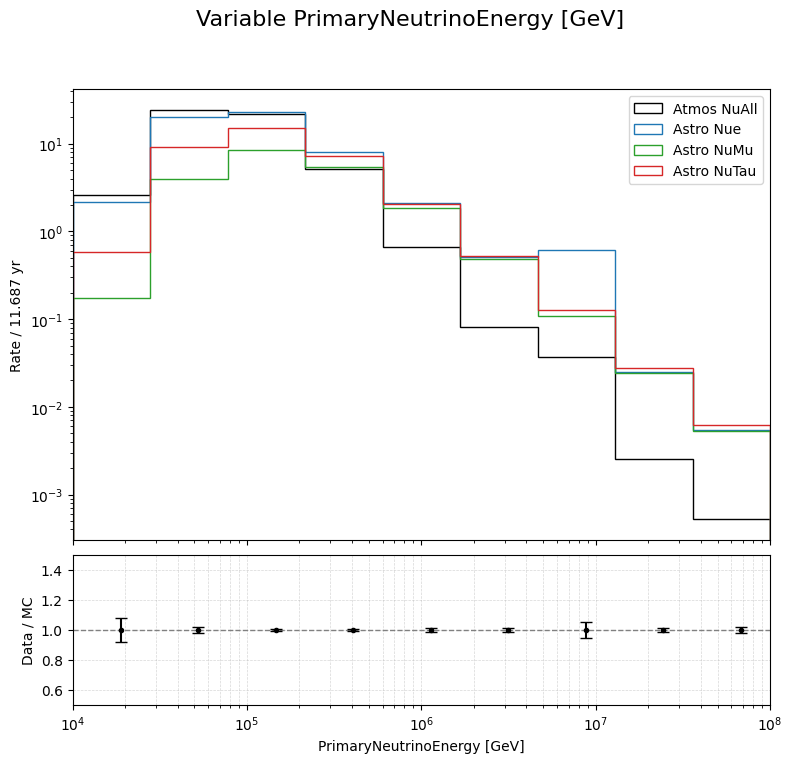

In [28]:
plot_distribution_single( base_key = "taureco_iceprod_v5", base_var_key1 = "I3MCWeightDict", base_var_key2 = "PrimaryNeutrinoEnergy",
                         variable_name = "PrimaryNeutrinoEnergy [GeV]", bins = np.geomspace(1e4, 1e8, 10), xscale = "log", yscale = "log", savename="PrimaryNeutrinoEnergy" )
